In [123]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.optimize, scipy.stats

In [124]:
# disable warnings due to matplotlib/pandas incompatibilities with latest Python 3
import warnings
warnings.filterwarnings("ignore")

In [125]:
# print lots of sig figs when printing arrays
np.set_printoptions(precision=18)

# Logistic model

\begin{aligned}
s_0 &= \text{ability of student} \\
c_0 &= \text{difficulty of course} \\
c_1 &= \text{discrimination of course} \\
p(s_0,c_0,c_1) &= \text{predicted grade for student in course} \\
&= c_1 s_0 + c_0 \\
g_{ik} &= \text{true grade for stduent $i$ in course $k$} \\
V &= \frac{1}{N_{\rm g}} \sum_{i,k} \Big(p(s_{0i},c_{0k},c_{1k}) - g_{ik}\Big)^2
+ \frac{1}{N_{\rm s}} \sum_i \alpha_{s0}(s_{0i} - s_0^*)^2
+ \frac{1}{N_{\rm c}} \sum_i \Big(\alpha_{c0}(c_{0k} - c_0^*)^2 + \alpha_{c1}(c_{1k} - c_1^*)^2\Big)
\end{aligned}

In [126]:
#default_c_params = np.array([0.0, 1.0, 0.0])
#def p(s, c):
#    return c[:,2] + (4 - c[:,2])/(1 + np.exp(-c[:,1]*(s[:,0] - c[:,0])))
default_c_params = np.array([2.0, 1.0])
def p(s, c):
    return c[:,1] * s[:,0] + c[:,0]

In [127]:
def s_penalty(s):
    return 1e-2 * s[0]**2

In [128]:
#def c_penalty(c):
#    return penalty_factor * (0.01 * c[0]**2 + (10 * (c[1] < 0) + (c[1] > 0)) * c[1]**2)
def c_penalty(c):
    return 1e-4 * c[0]**2 + 1e-2 * c[1]**2

# Visualize model

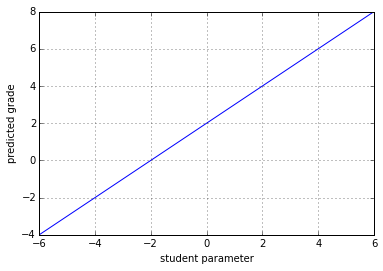

In [129]:
s = np.linspace(-6, 6, 100)
pv = p(np.atleast_2d(s).transpose(), np.atleast_2d(default_c_params))
plt.plot(s, pv)
plt.grid()
plt.xlabel('student parameter')
plt.ylabel('predicted grade');

# Grade data

In [130]:
grades = pd.read_csv('WIDER course data v2/Course_Hist.csv')
grades.columns

Index(['id', 'CRN', 'Course_Term', 'Course_Term_Desc', 'Credit_Type',
       'Course_Subject_Code', 'Course_Number', 'Course_Section_Number',
       'Course_Title', 'Course_Grade', 'Course_Level', 'Course_Grading_Mode',
       'Course_Credit_Hour', 'Seqno', 'Repeat_Flag'],
      dtype='object')

### Add "Course" labels to data

The `Course` is a string like `TAM 212` consisting of the subject code, a space, and the course number.

In [131]:
grades['Course'] = grades['Course_Subject_Code'] + ' ' + grades['Course_Number'].astype('str')

### Translate letter grades into numerical scores

In [132]:
letter_grades = {
    'A+': 4.00,
    'A+H': 4.00,
    'A':  4.00,
    'AH':  4.00,
    'A-': 3.67,
    'A-H': 3.67,
    'B+': 3.33,
    'B+H': 3.33,
    'B':  3.00,
    'BH':  3.00,
    'B-': 2.67,
    'B-H': 2.67,
    'C+': 2.33,
    'C':  2.00,
    'C-': 1.67,
    'D+': 1.33,
    'D':  1.00,
    'D-': 0.67,
    'F':  0.00,
    'ABS': 0.00,
}
def grade_to_score(g):
    if g in letter_grades:
        return letter_grades[g]
    else:
        return -1.0

In [133]:
grades['Score'] = grades['Course_Grade'].apply(grade_to_score)

Unrecognized grades are mapped to -1, so now we drop all rows that have negative scores.

In [134]:
keep_grades = (grades['Score'] >= 0)
print("dropping %d grades (out of %d)" % (len(keep_grades) - keep_grades.sum(), len(keep_grades)))
grades = grades[keep_grades]

dropping 120956 grades (out of 2210504)


# Course sizes

In [135]:
course_sizes = grades.groupby('Course').agg(len)['Score'].copy()

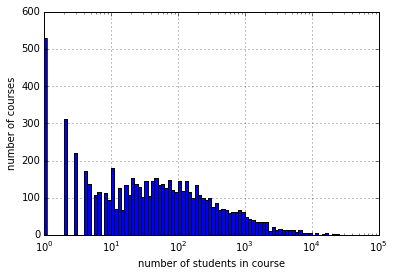

In [136]:
plt.hist(course_sizes, bins=np.logspace(0, 5, 101))
plt.gca().set_xscale('log')
plt.grid()
plt.xlabel('number of students in course');
plt.ylabel('number of courses');

# Number of courses per student

In [137]:
student_course_counts = grades.groupby('id').agg(len)['Score']

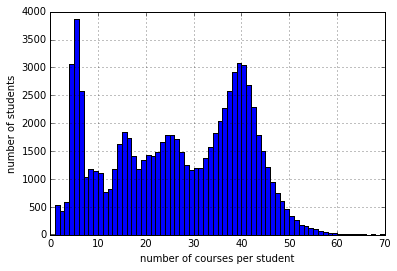

In [138]:
student_course_counts.plot(kind='hist', bins=np.linspace(0, 70, 71))
plt.grid()
plt.xlabel('number of courses per student')
plt.ylabel('number of students');

# Filter out small courses and students with few courses

In [139]:
#grades = grades.groupby('id').filter(lambda x: len(x) >= 12)

In [140]:
#grades = grades.groupby('Course').filter(lambda x: len(x) >= 30)

In [141]:
#grades = grades.groupby('id').filter(lambda x: len(x) >= 12)

# Repack data for efficient access while fitting

In [142]:
grades_by_student = grades.groupby('id')
grades_by_course = grades.groupby('Course')

In [143]:
student_ids = np.array(sorted(list(grades_by_student.groups.keys())))
courses = np.array(sorted(list(grades_by_course.groups.keys())))

In [144]:
n_students = len(student_ids)
n_courses = len(courses)
n_grades = grades.shape[0]

In [145]:
student_idx_by_id = {}
for (s_idx, id) in enumerate(student_ids):
    student_idx_by_id[id] = s_idx

In [146]:
course_idx_by_course = {course: c_idx for (c_idx, course) in enumerate(courses)}

In [147]:
course_idx_by_student_idx = {}
true_scores_by_student_idx = {}
for (s_idx, id) in enumerate(student_ids):
    course_idx_by_student_idx[s_idx] = np.array([course_idx_by_course[course] for course in grades_by_student.get_group(id)['Course']])
    true_scores_by_student_idx[s_idx] = grades_by_student.get_group(id)['Score'].values

In [148]:
student_idx_by_course_idx = {}
true_scores_by_course_idx = {}
for (c_idx, course) in enumerate(courses):
    student_idx_by_course_idx[c_idx] = np.array([student_idx_by_id[id] for id in grades_by_course.get_group(course)['id']])
    true_scores_by_course_idx[c_idx] = grades_by_course.get_group(course)['Score'].values

# Raw GPAs per student and per course

In [149]:
s_gpa = np.zeros(n_students)
s_gpa_std = np.zeros(n_students)
for s_idx in range(n_students):
    true_scores = true_scores_by_student_idx[s_idx]
    s_gpa[s_idx] = true_scores.mean()
    s_gpa_std[s_idx] = true_scores.std()

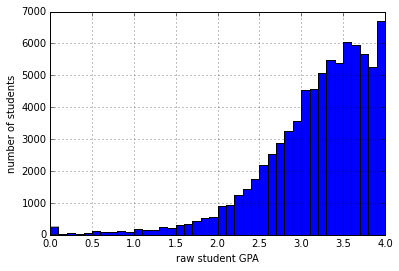

In [150]:
plt.hist(s_gpa, bins=np.linspace(0, 4, 41))
plt.grid()
plt.xlabel('raw student GPA')
plt.ylabel('number of students');

Dashed line shows theoretical upper-bound


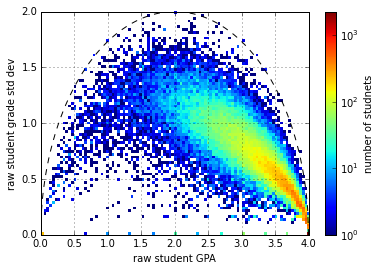

In [151]:
plt.hist2d(s_gpa, s_gpa_std, [np.linspace(0, 4, 100), np.linspace(0, 2, 80)], norm=matplotlib.colors.LogNorm());
plt.grid()
x = np.linspace(0, 4, 300)
plt.plot(x, np.sqrt((x/4) * (1 - (x/4))) * 4, 'k--')
print("Dashed line shows theoretical upper-bound")
cbar = plt.colorbar()
cbar.set_label('number of studnets')
plt.xlabel('raw student GPA');
plt.ylabel('raw student grade std dev');

In [152]:
c_gpa = np.zeros(n_courses)
c_gpa_std = np.zeros(n_courses)
for c_idx in range(n_courses):
    true_scores = true_scores_by_course_idx[c_idx]
    c_gpa[c_idx] = true_scores.mean()
    c_gpa_std[c_idx] = true_scores.std()

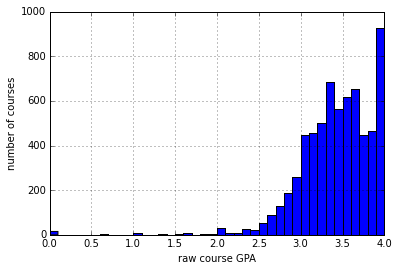

In [153]:
plt.hist(c_gpa, bins=np.linspace(0, 4, 41))
plt.grid()
plt.xlabel('raw course GPA')
plt.ylabel('number of courses');

Dashed line shows theoretical upper-bound


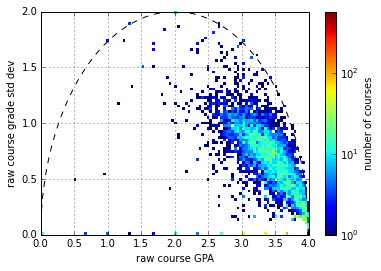

In [154]:
plt.hist2d(c_gpa, c_gpa_std, [np.linspace(0, 4, 100), np.linspace(0, 2, 80)], norm=matplotlib.colors.LogNorm());
plt.grid()
x = np.linspace(0, 4, 300)
plt.plot(x, np.sqrt((x/4) * (1 - (x/4))) * 4, 'k--')
print("Dashed line shows theoretical upper-bound")
cbar = plt.colorbar()
cbar.set_label('number of courses')
plt.xlabel('raw course GPA');
plt.ylabel('raw course grade std dev');

# Number of courses

In [155]:
s_counts = np.zeros(n_students)
for s_idx in range(n_students):
    s_counts[s_idx] = len(true_scores_by_student_idx[s_idx])

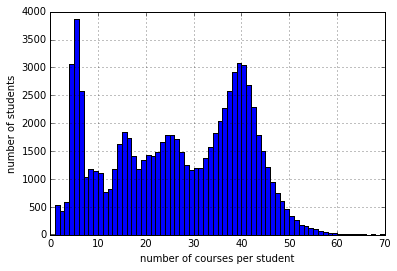

In [156]:
plt.hist(s_counts, bins=np.linspace(0, 70, 71))
plt.grid()
plt.xlabel('number of courses per student')
plt.ylabel('number of students');

In [157]:
c_counts = np.zeros(n_courses)
for c_idx in range(n_courses):
    c_counts[c_idx] = len(true_scores_by_course_idx[c_idx])

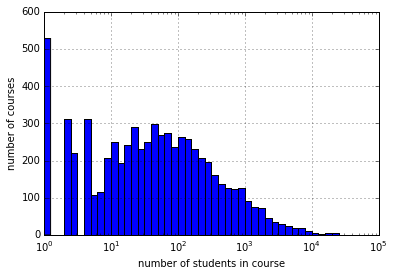

In [158]:
plt.hist(c_counts, bins=np.logspace(0, 5, 51))
plt.gca().set_xscale('log')
plt.grid()
plt.xlabel('number of students in course')
plt.ylabel('number of courses');

# Fitting

In [159]:
def total_cost():
    V = 0
    for s_idx in range(n_students):
        loc_s = s[s_idx,:]
        loc_c = c[course_idx_by_student_idx[s_idx],:]
        true_scores = true_scores_by_student_idx[s_idx]
        pred_scores = p(np.atleast_2d(loc_s), loc_c)
        V += np.sum((true_scores - pred_scores)**2) / n_grades
    for s_idx in range(n_students):
        V += s_penalty(s[s_idx,:]) / n_students
    for c_idx in range(n_courses):
        V += c_penalty(c[c_idx,:]) / n_courses
    return V

In [160]:
# update a single student parameter from all their courses
def update_one_s(s_idx):
    init_loc_s = s[s_idx,:]
    loc_c = c[course_idx_by_student_idx[s_idx],:]
    true_scores = true_scores_by_student_idx[s_idx]
    def cost(loc_s):
        pred_scores = p(np.atleast_2d(loc_s), loc_c)
        v = np.sum((true_scores - pred_scores)**2) * n_students / n_grades
        return v + s_penalty(loc_s)
    res = scipy.optimize.minimize(cost, init_loc_s)
    return res.x

In [161]:
# fit a single course parameter from all the students in the course
def update_one_c(c_idx):
    init_loc_c = c[c_idx,:]
    loc_s = s[student_idx_by_course_idx[c_idx],:]
    true_scores = true_scores_by_course_idx[c_idx]
    def cost(loc_c):
        pred_scores = p(loc_s, np.atleast_2d(loc_c))
        v = np.sum((true_scores - pred_scores)**2) * n_courses / n_grades
        return v + c_penalty(loc_c)
    res = scipy.optimize.minimize(cost, init_loc_c)
    return res.x

In [162]:
# update all student parameters given fixed course parameters
def update_s():
    for s_idx in range(n_students):
        #if s_idx % 10000 == 0:
        #    print("%d/%d" % (s_idx, n_students))
        s[s_idx,:] = update_one_s(s_idx)

In [163]:
# update all course parameters given fixed student parameters
def update_c():
    for c_idx in range(n_courses):
        #if c_idx % 1000 == 0:
        #    print("%d/%d" % (c_idx, n_courses))
        c[c_idx,:] = update_one_c(c_idx)

# Brute force search

In [164]:
# find a single best student parameter
def search_one_s(s_idx):
    loc_c = c[course_idx_by_student_idx[s_idx],:]
    true_scores = true_scores_by_student_idx[s_idx]
    def cost(loc_s):
        pred_scores = p(np.atleast_2d(loc_s), loc_c)
        v = np.linalg.norm((true_scores - pred_scores) / true_scores.shape[0])
        return v + s_penalty(loc_s)
    v_opt = 1e10
    loc_s_opt = 0
    for s0 in np.linspace(-5, 5, 10):
        loc_s = np.array([s0])
        v = cost(loc_s)
        if v < v_opt:
            v_opt = v
            loc_s_opt = loc_s
    return loc_s_opt

In [165]:
# find a single best course parameter
def search_one_c(c_idx):
    loc_s = s[student_idx_by_course_idx[c_idx],:]
    true_scores = true_scores_by_course_idx[c_idx]
    def cost(loc_c):
        pred_scores = p(loc_s, np.atleast_2d(loc_c))
        v = np.linalg.norm((true_scores - pred_scores) / true_scores.shape[0])
        return v + c_penalty(loc_c)
    v_opt = 1e10
    loc_c_opt = 0
    for c0 in np.linspace(-10, 0, 10):
        for c1 in np.linspace(0, 2.5, 10):
            loc_c = np.array([c0, c1])
            v = cost(loc_c)
            if v < v_opt:
                v_opt = v
                loc_c_opt = loc_c
    return loc_c_opt

In [166]:
def search_s():
    #max_ds = 0
    for s_idx in range(n_students):
        #if s_idx % 1000 == 0:
            #print('%d/%d' % (s_idx, n_students))
        #    print('%d/%d: max_ds = %f' % (s_idx, n_students, max_ds))
        new_loc_s = search_one_s(s_idx)
        s[s_idx,:] = new_loc_s
        #ds = np.abs(new_loc_s[0] - s[s_idx,0])
        #max_ds = max(max_ds, ds)
    #return max_ds
#max_ds = search_s()
#print('max_ds = %f' % max_ds)

In [167]:
def search_c():
    #max_dc = np.array([0, 0])
    for c_idx in range(n_courses):
        #if c_idx % 100 == 0:
            #print('%d/%d' % (c_idx, n_courses))
        #    print('%d/%d: max_dc = %s' % (c_idx, n_courses, max_dc))
        new_loc_c = search_one_c(c_idx)
        c[c_idx,:] = new_loc_c
        #dc = np.abs(new_loc_c - c[c_idx,:])
        #max_dc = np.maximum(max_dc, dc)
    #return max_dc
#max_dc = search_c()
#print('max_dc = %s' % max_dc)

# Initial values

In [168]:
# initialize students with their GPAs
s = np.zeros((n_students, 1))
s[:,0] = (s_gpa - s_gpa.mean()) / s_gpa.std()

In [169]:
# initialize students with their GPA rank
ranks = [(s_i, s_gpa[s_i]) for s_i in range(n_students)]
ranks.sort(key = lambda r: r[1])
s = np.zeros((n_students, 1))
for (i, r) in enumerate(ranks):
    s[r[0]] = i
s[:,0] = (s[:,0] - s[:,0].mean()) / s[:,0].std()

In [170]:
# initialize courses with default values
c = np.zeros((n_courses, len(default_c_params)))
for c_idx in range(n_courses):
    c[c_idx,:] = default_c_params

# Main solver

In [171]:
def iterate():
    max_iteration = 4
    for i in range(max_iteration):
        s_old = s.copy()
        c_old = c.copy()
        v_old = total_cost()
        search_c()
        search_s()
        ds = np.linalg.norm(s - s_old) / s.shape[0]
        dc = np.linalg.norm(c - c_old) / c.shape[0]
        v = total_cost()
        dv = np.abs(v - v_old)
        print("searth iteration %d, ds = %f, dc = %f, dv = %f" % (i, ds, dc, dv))

    max_iteration = 100
    for i in range(max_iteration):
        s_old = s.copy()
        c_old = c.copy()
        v_old = total_cost()
        update_c()
        update_s()
        ds = np.linalg.norm(s - s_old) / s.shape[0]
        dc = np.linalg.norm(c - c_old) / c.shape[0]
        v = total_cost()
        dv = np.abs(v - v_old)
        print("opt iteration %d, ds = %f, dc = %f, dv = %f" % (i, ds, dc, dv))
        if ds < 1e-6 and dc < 1e-6:
            print("successful termination")
            break
    else:
        print("iteration did not successfully terminate")

In [172]:
iterate()

searth iteration 0, ds = 0.005883, dc = 0.026997, dv = 7.445814
searth iteration 1, ds = 0.006521, dc = 0.016744, dv = 7.012824
searth iteration 2, ds = 0.001824, dc = 0.007772, dv = 1.658316
searth iteration 3, ds = 0.000962, dc = 0.006968, dv = 0.072582
opt iteration 0, ds = 0.001949, dc = 0.037610, dv = 0.485505
opt iteration 1, ds = 0.000371, dc = 0.004376, dv = 0.017967
opt iteration 2, ds = 0.000229, dc = 0.001433, dv = 0.005604
opt iteration 3, ds = 0.000181, dc = 0.000948, dv = 0.003439
opt iteration 4, ds = 0.000153, dc = 0.000699, dv = 0.002495
opt iteration 5, ds = 0.000135, dc = 0.000540, dv = 0.001980
opt iteration 6, ds = 0.000122, dc = 0.000432, dv = 0.001674
opt iteration 7, ds = 0.000113, dc = 0.000357, dv = 0.001480
opt iteration 8, ds = 0.000106, dc = 0.000305, dv = 0.001351
opt iteration 9, ds = 0.000101, dc = 0.000269, dv = 0.001262
opt iteration 10, ds = 0.000097, dc = 0.000245, dv = 0.001197
opt iteration 11, ds = 0.000094, dc = 0.000228, dv = 0.001147
opt iterat

s_0: [-4.782542,2.166235], mu = 0.881851, std = 0.777189
c_0: [-0.705572,4.039562], mu = 2.974077, std = 0.756691
c_1: [-0.493430,2.364701], mu = 0.484196, std = 0.409064


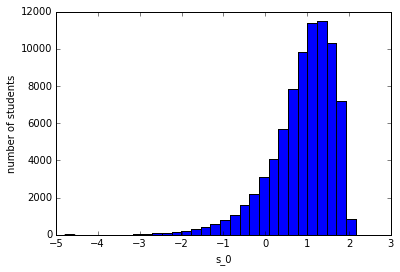

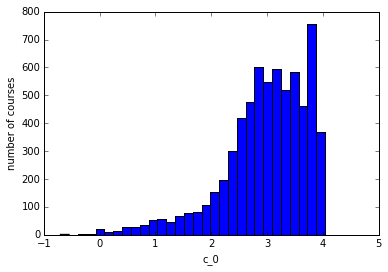

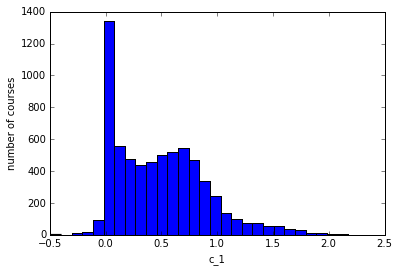

In [173]:
print("s_0: [%f,%f], mu = %f, std = %f" % (s[:,0].min(), s[:,0].max(), s[:,0].mean(), s[:,0].std()))
print("c_0: [%f,%f], mu = %f, std = %f" % (c[:,0].min(), c[:,0].max(), c[:,0].mean(), c[:,0].std()))
print("c_1: [%f,%f], mu = %f, std = %f" % (c[:,1].min(), c[:,1].max(), c[:,1].mean(), c[:,1].std()))
#print("c_2: [%f,%f], mu = %f, std = %f" % (c[:,2].min(), c[:,2].max(), c[:,2].mean(), c[:,2].std()))
plt.figure();
plt.hist(s[:,0], bins=30);
plt.xlabel('s_0');
plt.ylabel('number of students');
plt.figure();
plt.hist(c[:,0], bins=30);
plt.xlabel('c_0');
plt.ylabel('number of courses');
plt.figure();
plt.hist(c[:,1], bins=30);
plt.xlabel('c_1');
plt.ylabel('number of courses');
#plt.figure()
#plt.hist(c[:,2], bins=30)
#plt.xlabel('c_2');

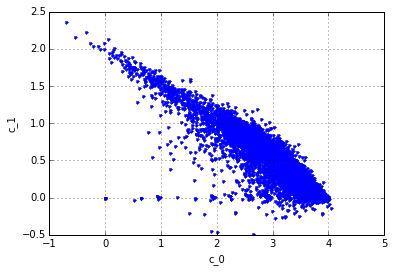

In [174]:
plt.plot(c[:,0],c[:,1],'.')
plt.grid();
plt.xlabel('c_0');
plt.ylabel('c_1');

# Debug course parameter fitting

In [175]:
#c_idx = list(np.logical_and(c[:,0] < 10, c[:,1] < 0)).index(True)
c_idx = 0
c_idx

0

In [176]:
courses[c_idx]

'AAS 100'

In [177]:
c[c_idx,:]

array([ 3.056237654332529363,  0.566794388217283229])

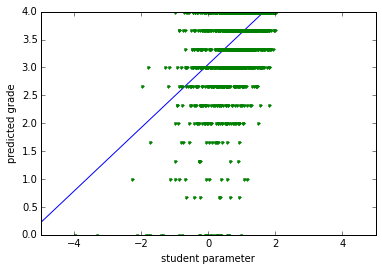

In [178]:
sv = np.linspace(-5, 5, 100)
pv = p(np.atleast_2d(sv).transpose(), np.atleast_2d(c[c_idx,:]))
plt.plot(sv, pv)
loc_s = s[student_idx_by_course_idx[c_idx],:]
true_scores = true_scores_by_course_idx[c_idx]
plt.plot(loc_s, true_scores, '.')
plt.xlim(-5, 5)
plt.ylim(0, 4)
plt.xlabel('student parameter')
plt.ylabel('predicted grade');

In [179]:
np.corrcoef(s[student_idx_by_course_idx[c_idx],0], true_scores_by_course_idx[c_idx])

array([[ 1.                  ,  0.524825440944195476],
       [ 0.524825440944195476,  1.                  ]])

In [180]:
c[c_idx,:]

array([ 3.056237654332529363,  0.566794388217283229])

In [181]:
def cost(loc_c):
    loc_s = s[student_idx_by_course_idx[c_idx],:]
    true_scores = true_scores_by_course_idx[c_idx]
    pred_scores = p(loc_s, np.atleast_2d(loc_c))
    v = np.linalg.norm((true_scores - pred_scores) / true_scores.shape[0])
    return v + c_penalty(loc_c)

In [182]:
cost(c[c_idx,:])

0.015303272645904305

In [183]:
v_min = 1e10
c_opt = [0,0]
c0_vals = np.linspace(-15, 15, 200)
c1_vals = np.linspace(-2.5, 2.5, 100)
v_arr = np.zeros((len(c0_vals), len(c1_vals)))
for (i_c0, c0) in enumerate(c0_vals):
    for (i_c1, c1) in enumerate(c1_vals):
        c_loc = np.array([c0, c1])
        v = cost(c_loc)
        v_arr[i_c0, i_c1] = v
        if v < v_min:
            v_min = v
            c_opt = c_loc
print("v_min = %f" % v_min)
print("c_opt = %s" % c_opt)

v_min = 0.013565
c_opt = [ 3.391959798994975017  0.227272727272727071]


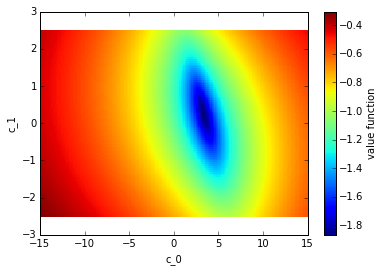

In [184]:
plt.pcolor(c0_vals, c1_vals, np.log10(v_arr).transpose())
cbar = plt.colorbar();
cbar.set_label('value function');
plt.xlabel('c_0');
plt.ylabel('c_1');

# Debug student parameter fitting

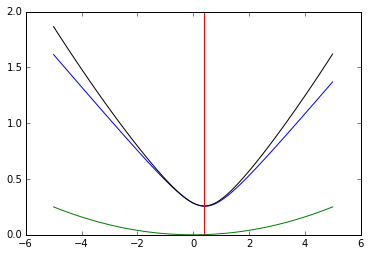

In [185]:
s_idx = 0
sv = np.linspace(-5, 5, 100)
loc_s = s[s_idx,:]
loc_c = c[course_idx_by_student_idx[s_idx],:]
true_scores = true_scores_by_student_idx[s_idx]
pv = np.zeros_like(sv);
pp = np.zeros_like(sv);
pt = np.zeros_like(sv);
for i in range(len(sv)):
    loc_s = np.array([sv[i]])
    pred_scores = p(np.atleast_2d(loc_s), loc_c)
    pv[i] = np.linalg.norm((true_scores - pred_scores) / true_scores.shape[0])
    pp[i] = s_penalty(loc_s)
    pt[i] = pv[i] + pp[i]
plt.plot(sv, pv, 'b-');
plt.plot(sv, pp, 'g-');
plt.plot(sv, pt, 'k-');
plt.axvline(s[s_idx,0], c='r')

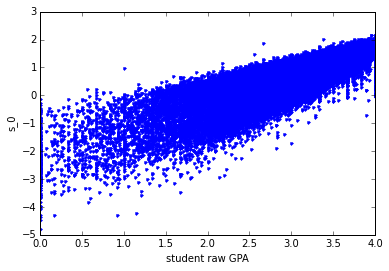

In [186]:
plt.plot(s_gpa, s[:,0],'.');
plt.xlabel('student raw GPA');
plt.ylabel('s_0');

# All-course student GPAs

What would a student's GPA be if they took every course?

In [187]:
s_allgpa = np.zeros(n_students)
s_allgpa_std = np.zeros(n_students)
for s_idx in range(n_students):
    loc_s = s[s_idx,:]
    loc_c = c[:,:]
    pred_scores = p(np.atleast_2d(loc_s), loc_c)
    s_allgpa[s_idx] = pred_scores.mean()
    s_allgpa_std[s_idx] = pred_scores.std()

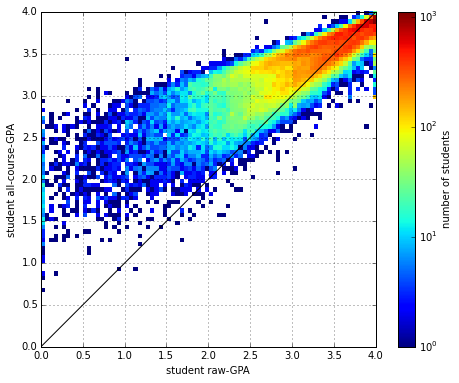

In [188]:
plt.figure(figsize=(8,6))
plt.hist2d(s_gpa, s_allgpa, [np.linspace(0, 4, 81), np.linspace(0, 4, 81)], norm=matplotlib.colors.LogNorm());
plt.plot([0, 4], [0, 4], 'k-')
plt.gca().set_aspect('equal')
plt.grid()
cbar = plt.colorbar();
cbar.set_label('number of students');
plt.xlabel('student raw-GPA');
plt.ylabel('student all-course-GPA');

# All-student course GPAs

What would a course's GPA be if they took every course?

In [189]:
c_allgpa = np.zeros(n_courses)
c_allgpa_std = np.zeros(n_courses)
for c_idx in range(n_courses):
    loc_c = c[c_idx,:]
    loc_s = s[:,:]
    pred_scores = p(loc_s, np.atleast_2d(loc_c))
    c_allgpa[c_idx] = pred_scores.mean()
    c_allgpa_std[c_idx] = pred_scores.std()

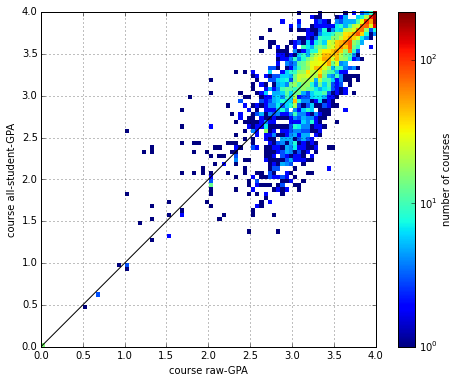

In [190]:
plt.figure(figsize=(8,6))
plt.hist2d(c_gpa, c_allgpa, [np.linspace(0, 4, 81), np.linspace(0, 4, 81)], norm=matplotlib.colors.LogNorm());
plt.plot([0, 4], [0, 4], 'k-')
plt.gca().set_aspect('equal');
plt.grid()
cbar = plt.colorbar();
cbar.set_label('number of courses');
plt.xlabel('course raw-GPA');
plt.ylabel('course all-student-GPA');

# Predicting student GPAs

In [191]:
s_rmse_gpa = np.zeros(n_students)
s_rmse_pred = np.zeros(n_students)
for s_idx in range(n_students):
    true_scores = true_scores_by_student_idx[s_idx]
    gpa = s_gpa[s_idx]
    errs_gpa = true_scores - gpa
    s_rmse_gpa[s_idx] = np.sqrt((errs_gpa**2).mean())
    
    loc_s = s[s_idx,:]
    loc_c = c[course_idx_by_student_idx[s_idx],:]
    pred_scores = p(np.atleast_2d(loc_s), loc_c)
    errs_pred = true_scores - pred_scores
    s_rmse_pred[s_idx] = np.sqrt((errs_pred**2).mean())

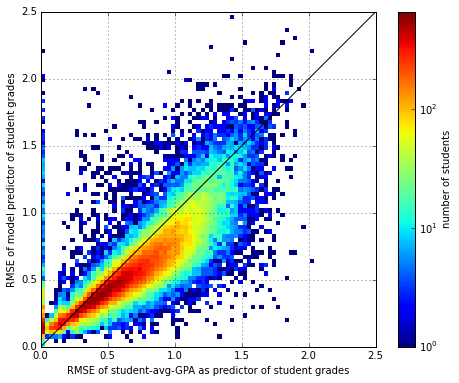

In [192]:
plt.figure(figsize=(8,6))
plt.hist2d(s_rmse_gpa, s_rmse_pred, [np.linspace(0, 2.5, 81), np.linspace(0, 2.5, 81)], norm=matplotlib.colors.LogNorm());
plt.plot([0, 2.5], [0, 2.5], 'k-')
plt.gca().set_aspect('equal');
plt.grid()
cbar = plt.colorbar();
cbar.set_label('number of students');
plt.xlabel('RMSE of student-avg-GPA as predictor of student grades');
plt.ylabel('RMSE of model predictor of student grades');

In [193]:
print('mean RMSE of student-avg-GPA as a predictor of student grades = %f' % s_rmse_gpa.mean())
print('mean RMSE of model predictor of student grades = %f' % s_rmse_pred.mean())

mean RMSE of student-avg-GPA as a predictor of student grades = 0.646285
mean RMSE of model predictor of student grades = 0.546390


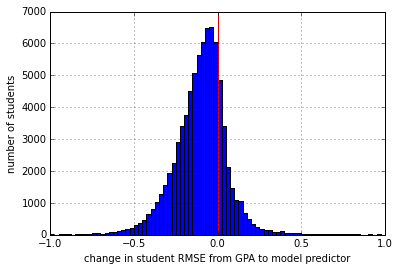

In [194]:
plt.hist(s_rmse_pred - s_rmse_gpa, bins=np.linspace(-1, 1, 81));
plt.xlim(-1, 1)
plt.grid()
plt.axvline(0, c='r')
plt.xlabel('change in student RMSE from GPA to model predictor')
plt.ylabel('number of students');

# Predicting course GPAs

In [195]:
c_rmse_gpa = np.zeros(n_courses)
c_rmse_pred = np.zeros(n_courses)
for c_idx in range(n_courses):
    true_scores = true_scores_by_course_idx[c_idx]
    gpa = c_gpa[c_idx]
    errs_gpa = true_scores - gpa
    c_rmse_gpa[c_idx] = np.sqrt((errs_gpa**2).mean())
    
    loc_c = c[c_idx,:]
    loc_s = s[student_idx_by_course_idx[c_idx],:]
    pred_scores = p(loc_s, np.atleast_2d(loc_c))
    errs_pred = true_scores - pred_scores
    c_rmse_pred[c_idx] = np.sqrt((errs_pred**2).mean())

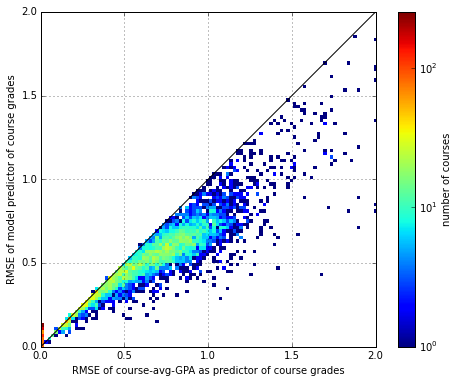

In [196]:
plt.figure(figsize=(8,6))
plt.hist2d(c_rmse_gpa, c_rmse_pred, [np.linspace(0, 2, 101), np.linspace(0, 2, 101)], norm=matplotlib.colors.LogNorm());
plt.plot([0, 2], [0, 2], 'k-')
plt.gca().set_aspect('equal');
plt.grid()
cbar = plt.colorbar();
cbar.set_label('number of courses');
plt.xlabel('RMSE of course-avg-GPA as predictor of course grades');
plt.ylabel('RMSE of model predictor of course grades');

In [197]:
print('mean RMSE of course-avg-GPA as a predictor of course grades = %f' % c_rmse_gpa.mean())
print('mean RMSE of model predictor of course grades = %f' % c_rmse_pred.mean())

mean RMSE of course-avg-GPA as a predictor of course grades = 0.591625
mean RMSE of model predictor of course grades = 0.472503


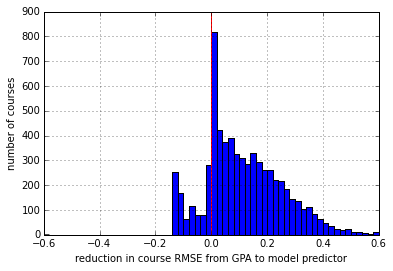

In [198]:
plt.hist(c_rmse_gpa - c_rmse_pred, bins=np.linspace(-0.6, 0.6, 61));
plt.xlim(-0.6, 0.6)
plt.grid()
plt.axvline(0, c='r')
plt.xlabel('reduction in course RMSE from GPA to model predictor')
plt.ylabel('number of courses');

# Total prediction RMSE

In [199]:
tot_sq_err_gpa = 0
tot_sq_err_pred = 0
n = 0
for s_idx in range(n_students):
    true_scores = true_scores_by_student_idx[s_idx]
    gpa = s_gpa[s_idx]
    errs_gpa = true_scores - gpa
    loc_s = s[s_idx,:]
    loc_c = c[course_idx_by_student_idx[s_idx],:]
    pred_scores = p(np.atleast_2d(loc_s), loc_c)
    errs_pred = true_scores - pred_scores
    tot_sq_err_gpa += np.sum(errs_gpa**2)
    tot_sq_err_pred += np.sum(errs_pred**2)
    n += len(true_scores)
rmse_gpa = np.sqrt(tot_sq_err_gpa / n)
rmse_pred = np.sqrt(tot_sq_err_pred / n)

In [200]:
print("mean RMSE using student-avg-GPA as predictor = %f" % rmse_gpa);
print("mean RMSE using model as predictor = %f" % rmse_pred);
print("reduction in RMSE = %f%%" % ((rmse_gpa - rmse_pred) / rmse_gpa * 100))

mean RMSE using student-avg-GPA as predictor = 0.735413
mean RMSE using model as predictor = 0.610995
reduction in RMSE = 16.918112%


# Export data

In [201]:
s_model = pd.DataFrame({
        'num_courses': pd.Series(s_counts, index=student_ids),
        'GPA': pd.Series(s_gpa, index=student_ids),
        'GPA_std': pd.Series(s_gpa_std, index=student_ids),
        's_0': pd.Series(s[:,0], index=student_ids),
        'all_GPA': pd.Series(s_allgpa, index=student_ids),
        'all_GPA_std': pd.Series(s_allgpa_std, index=student_ids),
        'RMSE_GPA': pd.Series(s_rmse_gpa, index=student_ids),
        'RMSE_pred': pd.Series(s_rmse_pred, index=student_ids),
    }, columns=['num_courses', 'GPA', 'GPA_std', 's_0', 'all_GPA', 'all_GPA_std', 'RMSE_GPA', 'RMSE_pred'],
                      index=pd.Index(student_ids, name='id'))

In [202]:
s_model.to_csv('student_model_linear.csv')

In [203]:
c_model = pd.DataFrame({
        'num_students': pd.Series(c_counts, index=courses),
        'GPA': pd.Series(c_gpa, index=courses),
        'GPA_std': pd.Series(c_gpa_std, index=courses),
        'c_0': pd.Series(c[:,0], index=courses),
        'c_1': pd.Series(c[:,1], index=courses),
        'all_GPA': pd.Series(c_allgpa, index=courses),
        'all_GPA_std': pd.Series(c_allgpa_std, index=courses),
        'RMSE_GPA': pd.Series(c_rmse_gpa, index=courses),
        'RMSE_pred': pd.Series(c_rmse_pred, index=courses),
    }, columns=['num_students', 'GPA', 'GPA_std', 'c_0', 'c_1', 'all_GPA', 'all_GPA_std', 'RMSE_GPA', 'RMSE_pred'],
                      index=pd.Index(courses, name='Course'))

In [204]:
c_model.to_csv('course_model_linear.csv')

In [205]:
all_preds = []
for s_idx in range(n_students):
    for (c_idx, true_score) in zip(course_idx_by_student_idx[s_idx], true_scores_by_student_idx[s_idx]):
        loc_s = s[s_idx,:]
        loc_c = c[c_idx,:]
        pred_score = p(np.atleast_2d(loc_s), np.atleast_2d(loc_c))[0]
        all_preds.append({
                'id': student_ids[s_idx],
                'Course': courses[c_idx],
                'true_score': true_score,
                'pred_score': pred_score,
            })
sc_model = pd.DataFrame(all_preds, columns=['id', 'Course', 'true_score', 'pred_score'])

In [206]:
sc_model.to_csv('student_course_model_linear.csv')